# Description
Model to classify Male and Female and shows <br>
- Effect of Image size on Accuracy and Learning
- Transfer Learning using VGG16, VGG19, Inception V3 and ResNet50

Images downloaded from Imagenet http://www.image-net.org/

## Load Dataset

In [7]:
!wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2017/04/a943287.csv

--2019-09-16 13:23:55--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2017/04/a943287.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.224.241.28, 13.224.241.13, 13.224.241.87, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.224.241.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7847932 (7.5M) [application/octet-stream]
Saving to: ‘a943287.csv.1’

a943287.csv.1       100%[===================>]   7.48M  30.1MB/s    in 0.2s    

2019-09-16 13:23:56 (30.1 MB/s) - ‘a943287.csv.1’ saved [7847932/7847932]



In [0]:
import pandas as pd, numpy as np
from skimage import io

In [5]:
data = pd.read_csv('/content/a943287.csv')
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


## Separate Males & Females Dataset

In [6]:
data_male = data[data['please_select_the_gender_of_the_person_in_the_picture']=="male"].reset_index(drop='index')
data_female = data[data['please_select_the_gender_of_the_person_in_the_picture']=="female"].reset_index(drop='index')
print(data_male.shape)
print(data_female.shape)
print(data_male.head())

(47595, 10)
(7367, 10)
     _unit_id  ...  user_id
0  1023132475  ...       40
1  1023132476  ...       42
2  1023132477  ...       44
3  1023132478  ...       47
4  1023132479  ...       50

[5 rows x 10 columns]


## Take only first 1000 Male and Female Dataset to speed up the training time

In [7]:
final_data = pd.concat([data_male[:1000],data_female[:1000]],axis=0).reset_index(drop='index')
final_data.shape

(2000, 10)

# Scenario 1: Handling Big images
### Donwload images from URL having size 300x300x3

In [13]:
x = []   # empty list to append Images
y = []   # empty list to append lables (male/female)
for i in range(final_data.shape[0]):
  if(i%100==0):
    print(i)
  try:
    image = io.imread(final_data.loc[i]['image_url'])   # read inages from URL given in csv file
    if(image.shape==(300,300,3)):
      x.append(image)
      y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
  except:
    continue

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


## Label Male with 1 and Female with 0

In [0]:
x2 = []
y2 = []
for i in range(len(x)):
  x2.append(x[i])
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [15]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

1.14.0


## Conver image to numpy Array

In [15]:
x2 = np.array(x2)
print(x2.shape)
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)   # reshape grayscale image to coloured if any
print(x2.shape)

(1751, 300, 300, 3)
(1751, 300, 300, 3)


## Create the Model
Notice that the final Image size is still large enough (37x37)

In [16]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(300,300,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 256)       0         
____

## Compile the Model

In [17]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
X = np.array(x2)/255.0    #  rescaling the images between 0 and 1
Y = np.array(y2)

In [0]:
# Split Dataset into Train and Test randomly (random_satte=42) with 10% allocated for test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1575, 300, 300, 3) (176, 300, 300, 3) (1575,) (176,)


In [21]:
np.max(X_train)

1.0

## Train the Model

In [22]:
history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 37s 24ms/sample - loss: 0.8343 - acc: 0.5346 - val_loss: 0.6724 - val_acc: 0.6420
Epoch 2/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.6520 - acc: 0.6438 - val_loss: 0.6647 - val_acc: 0.6193
Epoch 3/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.6518 - acc: 0.6165 - val_loss: 0.6852 - val_acc: 0.5398
Epoch 4/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.6534 - acc: 0.6330 - val_loss: 0.6669 - val_acc: 0.5966
Epoch 5/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.6305 - acc: 0.6330 - val_loss: 0.6808 - val_acc: 0.6023
Epoch 6/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.6105 - acc: 0.6603 - val_loss: 0.6960 - val_acc: 0.6761
Epoch 7/10
1575/1575 [==============================] - 28s 18ms/sample - loss: 0.5473 - acc: 0.7086 - val_loss: 0.6391 - val

## Plot Accuracy and Loss Graph

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


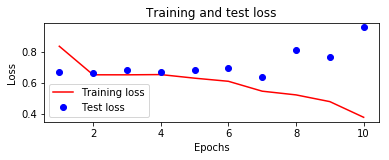

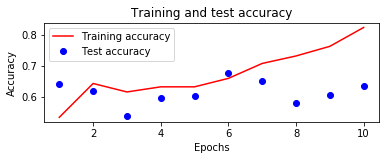

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(2,1,2)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Scenario 2: Small images

In [0]:
import cv2
x2 = []
y2 = []
for i in range(len(x)):
  img = cv2.resize(x[i],(50,50))  # resize images to 50x50x3
  x2.append(img)
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [25]:
np.array(x2).shape

(1751, 50, 50, 3)

In [0]:
x2 = np.array(x2)
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)

In [27]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 512)        

In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X = np.array(x2)/255.0
Y = np.array(y2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.7102 - acc: 0.5137 - val_loss: 0.6969 - val_acc: 0.5057
Epoch 2/10
1575/1575 [==============================] - 1s 762us/sample - loss: 0.6830 - acc: 0.5651 - val_loss: 0.6571 - val_acc: 0.6364
Epoch 3/10
1575/1575 [==============================] - 1s 781us/sample - loss: 0.6266 - acc: 0.6616 - val_loss: 0.6377 - val_acc: 0.6591
Epoch 4/10
1575/1575 [==============================] - 1s 778us/sample - loss: 0.5645 - acc: 0.7035 - val_loss: 0.6450 - val_acc: 0.6534
Epoch 5/10
1575/1575 [==============================] - 1s 767us/sample - loss: 0.5111 - acc: 0.7606 - val_loss: 0.5730 - val_acc: 0.6818
Epoch 6/10
1575/1575 [==============================] - 1s 773us/sample - loss: 0.4704 - acc: 0.7733 - val_loss: 0.5824 - val_acc: 0.6705
Epoch 7/10
1575/1575 [==============================] - 1s 774us/sample - loss: 0.4168 - acc: 0.8051 - val_loss: 0.5164 - val_a

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


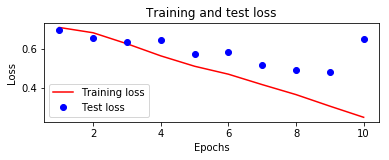

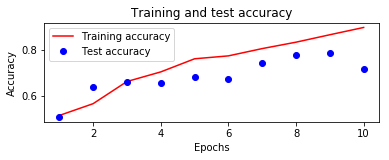

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Aggressive pooling on big images

In [0]:
x2 = []
y2 = []
for i in range(len(x)):
  x2.append(x[i])
  img_label = np.where(y[i]=="male",1,0)
  y2.append(img_label)

In [0]:
x2 = np.array(x2)
x2 = x2.reshape(x2.shape[0],x2.shape[1],x2.shape[2],3)

In [32]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',input_shape=(300,300,3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 99, 99, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 33, 33, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 33, 256)       295168    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 512)      

In [33]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X = np.array(x2)/255.0
Y = np.array(y2)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

history = model.fit(X_train, y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test, y_test))

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 16s 10ms/sample - loss: 0.7340 - acc: 0.5143 - val_loss: 0.6845 - val_acc: 0.4943
Epoch 2/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.6574 - acc: 0.6152 - val_loss: 0.6766 - val_acc: 0.6193
Epoch 3/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.6392 - acc: 0.6451 - val_loss: 0.6701 - val_acc: 0.6364
Epoch 4/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.6091 - acc: 0.6667 - val_loss: 0.6361 - val_acc: 0.6534
Epoch 5/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.5796 - acc: 0.6832 - val_loss: 0.6380 - val_acc: 0.6250
Epoch 6/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.5546 - acc: 0.7124 - val_loss: 0.6734 - val_acc: 0.6591
Epoch 7/10
1575/1575 [==============================] - 13s 8ms/sample - loss: 0.4988 - acc: 0.7397 - val_loss: 0.6158 - val_acc: 

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


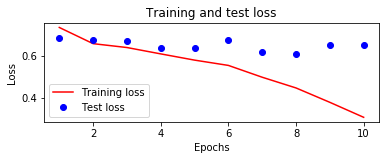

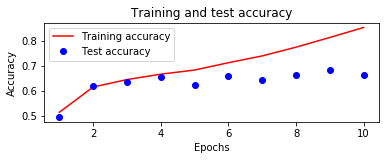

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'bo', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(2,1,2)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'bo', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# VGG16 architecture

In [0]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import preprocess_input
vgg16_model = vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(300,300,3))

In [36]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [37]:
import cv2
x2_vgg16 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = vgg16_model.predict(img.reshape(1,300,300,3))
    x2_vgg16.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [38]:
x2_vgg16 = np.array(x2_vgg16)
x2_vgg16.shape

(1751, 1, 9, 9, 512)

In [39]:
x2_vgg16= x2_vgg16.reshape(x2_vgg16.shape[0],x2_vgg16.shape[2],x2_vgg16.shape[3],x2_vgg16.shape[4])
x2_vgg16.shape

(1751, 9, 9, 512)

In [0]:
Y = np.array(y2)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2_vgg16,Y, test_size=0.1, random_state=42)

In [42]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1575, 9, 9, 512) (176, 9, 9, 512) (1575,) (176,)


In [43]:
np.max(X_train)

691.86755

In [44]:
model_vgg16 = Sequential()
model_vgg16.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_vgg16.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(512, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
____________________________________________

In [0]:
model_vgg16.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [46]:
np.mean(y_train)

0.48507936507936505

In [47]:
history_vgg16 = model_vgg16.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.3671 - acc: 0.8260 - val_loss: 0.2171 - val_acc: 0.9091
Epoch 2/10
1575/1575 [==============================] - 1s 750us/sample - loss: 0.1276 - acc: 0.9556 - val_loss: 0.2266 - val_acc: 0.8920
Epoch 3/10
1575/1575 [==============================] - 1s 745us/sample - loss: 0.0423 - acc: 0.9886 - val_loss: 0.3583 - val_acc: 0.8920
Epoch 4/10
1575/1575 [==============================] - 1s 768us/sample - loss: 0.0128 - acc: 0.9981 - val_loss: 0.3770 - val_acc: 0.8977
Epoch 5/10
1575/1575 [==============================] - 1s 766us/sample - loss: 0.0079 - acc: 0.9994 - val_loss: 0.5072 - val_acc: 0.8864
Epoch 6/10
1575/1575 [==============================] - 1s 745us/sample - loss: 0.0015 - acc: 1.0000 - val_loss: 0.5424 - val_acc: 0.8864
Epoch 7/10
1575/1575 [==============================] - 1s 760us/sample - loss: 7.1358e-04 - acc: 1.0000 - val_loss: 0.5791 - v

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


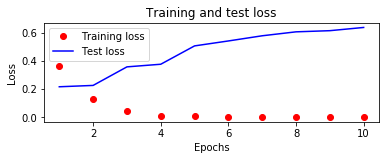

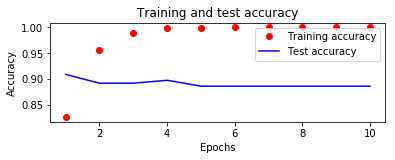

In [50]:
history_dict = history_vgg16.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, history_vgg16.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(2,1,2)
plt.plot(epochs, history_vgg16.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [51]:
y_pred = model_vgg16.predict(X_test/np.max(X_train))
y_pred.shape

(176, 1)

In [52]:
np.abs(y_pred.flatten()-y_test)[27]

0.0

In [53]:
np.argsort(np.abs(y_pred.flatten()-y_test))

array([ 87,  28,  58, 102,  95,  94,  92,  34,  35,  88,  85,  84,  43,
        81,  45,  80,  48,  78,  77,  51,  52,  73,  64,  57,  27, 105,
       104, 112, 167, 164, 163, 160,   5,   6,   7, 154,   9, 153,  25,
        13, 152, 151, 124, 127,  20, 138, 143, 147,  18, 150,  63,  40,
        46, 132,  89,  76,  90,  11,  54,  42, 175,  47, 111,  22,   4,
        50,  21,  37,  56,  71,  96,  15, 122,  12,   8, 149,  98,  53,
       174, 121,  44, 172, 141, 123,  66, 109,  91, 170, 144, 125, 168,
       145,  24, 115,  62, 126,  55, 130,  60,  30,  49, 156,  39, 171,
       133, 146, 110,  59, 158, 159, 162, 116, 103,  33,   3,  19, 139,
        16,  70, 165, 107, 166,  26,  93,   0,  23,  74,  79,  29,  38,
        41, 142, 169,  10, 113, 137,  72,  75, 118, 140, 173, 101,  65,
       106, 108,   1, 119,  14, 161,  83,  61, 155, 129,  68, 117,  86,
        67,  17,   2,  99, 114, 148, 120, 157,  82, 135,  32, 100, 136,
       134,  97,  69,  31, 131, 128,  36])

In [0]:
y_pred2 = np.where(y_pred>0.5,1,0)

In [0]:
from sklearn.model_selection import train_test_split
img_train, img_test, y_train, y_test = train_test_split(x,Y, test_size=0.1, random_state=42)

In [0]:
y_test_char = np.where(y_test==0,'F','M')

In [0]:
y_pred_char = np.where(y_pred>0.5,'M','F')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


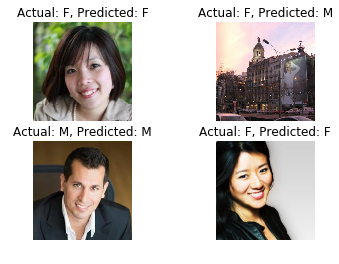

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(221)
plt.imshow(img_test[85])
plt.title('Actual: '+str(y_test_char[85])+', '+'Predicted: '+str((y_pred_char[85][0])))
plt.grid('off')
plt.axis('off')
plt.subplot(222)
plt.title('Actual: '+str(y_test_char[32])+', '+'Predicted: '+str((y_pred_char[32][0])))
plt.imshow(img_test[32])
plt.grid('off')
plt.axis('off')
plt.subplot(223)
plt.title('Actual: '+str(y_test_char[83])+', '+'Predicted: '+str((y_pred_char[83][0])))
plt.imshow(img_test[83])
plt.grid('off')
plt.axis('off')
plt.subplot(224)
plt.title('Actual: '+str(y_test_char[46])+', '+'Predicted: '+str((y_pred_char[46][0])))
plt.imshow(img_test[46])
plt.grid('off')
plt.axis('off')
plt.show()

# VGG19 architecture

In [60]:
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import preprocess_input
vgg19_model = vgg19.VGG19(include_top=False, weights='imagenet',input_shape=(300,300,3))

vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [61]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = vgg19_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [62]:
x2 = np.array(x2)
x2.shape

(1751, 1, 9, 9, 512)

In [63]:
x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

(1751, 9, 9, 512)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

In [65]:
model_vgg19 = Sequential()
model_vgg19.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_vgg19.add(MaxPooling2D(pool_size=(2, 2)))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dropout(0.5))
model_vgg19.add(Dense(1, activation='sigmoid'))
model_vgg19.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 7, 7, 512)         2359808   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2359808   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 4,720,129
Trainable params: 4,720,129
Non-trainable params: 0
____________________________________________

In [0]:
model_vgg19.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [67]:
history_vgg19 = model_vgg19.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.3868 - acc: 0.8184 - val_loss: 0.3123 - val_acc: 0.8864
Epoch 2/10
1575/1575 [==============================] - 1s 833us/sample - loss: 0.1376 - acc: 0.9530 - val_loss: 0.4031 - val_acc: 0.8807
Epoch 3/10
1575/1575 [==============================] - 1s 838us/sample - loss: 0.0562 - acc: 0.9867 - val_loss: 0.5122 - val_acc: 0.8807
Epoch 4/10
1575/1575 [==============================] - 1s 817us/sample - loss: 0.0229 - acc: 0.9943 - val_loss: 0.5209 - val_acc: 0.8807
Epoch 5/10
1575/1575 [==============================] - 1s 791us/sample - loss: 0.0070 - acc: 0.9987 - val_loss: 0.6627 - val_acc: 0.8920
Epoch 6/10
1575/1575 [==============================] - 1s 811us/sample - loss: 0.0017 - acc: 1.0000 - val_loss: 0.7221 - val_acc: 0.8864
Epoch 7/10
1575/1575 [==============================] - 1s 766us/sample - loss: 9.2192e-04 - acc: 1.0000 - val_loss: 0.7820 - v

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


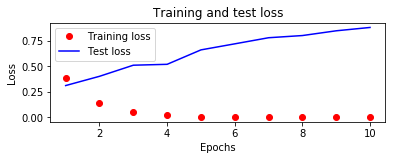

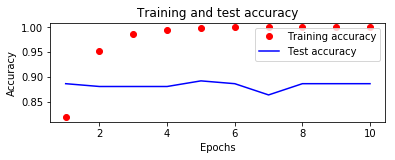

In [68]:
history_dict = history_vgg19.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(211)
plt.plot(epochs, history_vgg19.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, history_vgg19.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [0]:
y_pred = model_vgg19.predict(X_test/np.max(X_train))

In [70]:
np.argsort(np.abs(y_pred.flatten() - y_test))

array([ 87,  89,  88,  85,  84,  78,  77,  76,  90,  74,  64,  63,  58,
        57,  53,  51,  48,  73,  46,  92,  95, 167, 164, 163, 154, 152,
       150, 147,  94, 143, 126, 124, 112, 105, 104, 102,  96, 138,  45,
       175,   4,  25,  27,   8,   5,  13,   6,  18,   9,  24,  35,  20,
        81,  62,  42, 153,  37,  55,  56, 151, 123,  79,   7,  21, 156,
        54,  52, 111,  28,  34,  40, 171,  26, 158, 132, 160,  33, 168,
       121,  98,  11,  19,  15,  22, 125,  49,  68,  12, 159, 172, 133,
         1, 149, 155, 106,  47, 115, 137, 127, 141, 170,  41, 118,  16,
       162, 144,  50, 173,  59,  83,  72,  38,  93,  65,  60, 139, 117,
        66, 103, 109,  44, 122, 108, 165,  75, 119, 113,   0, 110, 161,
       146,   3, 142,  80,  71,  29,  91, 135,  23, 116, 101, 130, 145,
        10,  39,  70, 140,  43,  61, 114, 107, 174,  86, 129,  14, 166,
       131,  32,  30,  99,   2,  17, 169, 120, 157, 148,  67,  82,  97,
        69, 136, 100, 128, 134,  31,  36])

In [0]:
y_pred_char = np.where(y_pred>0.5,'M','F')
y_test_char = np.where(y_test==0,'F','M')

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


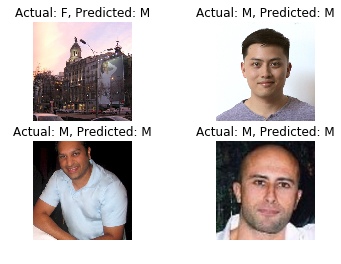

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(2,2,1)
plt.imshow(img_test[32])
plt.title('Actual: '+str(y_test_char[32])+', '+'Predicted: '+str((y_pred_char[32][0])))
plt.grid('off')
plt.axis('off')
plt.subplot(2,2,2)
plt.title('Actual: '+str(y_test_char[119])+', '+'Predicted: '+str((y_pred_char[119][0])))
plt.imshow(img_test[119])
plt.grid('off')
plt.axis('off')
plt.subplot(2,2,3)
plt.title('Actual: '+str(y_test_char[107])+', '+'Predicted: '+str((y_pred_char[107][0])))
plt.imshow(img_test[107])
plt.grid('off')
plt.axis('off')
plt.subplot(2,2,4)
plt.title('Actual: '+str(y_test_char[71])+', '+'Predicted: '+str((y_pred_char[71][0])))
plt.imshow(img_test[71])
plt.grid('off')
plt.axis('off')
plt.show()

# Inception v3 architecture

In [73]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import plot_model
inception_model = inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(300,300,3))

inception_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [74]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = inception_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)
	
x2 = np.array(x2)
x2.shape

x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [75]:
model_inception_v3 = Sequential()
model_inception_v3.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_inception_v3.add(MaxPooling2D(pool_size=(2, 2)))
model_inception_v3.add(Flatten())
model_inception_v3.add(Dense(512, activation='relu'))
model_inception_v3.add(Dropout(0.5))
model_inception_v3.add(Dense(1, activation='sigmoid'))
model_inception_v3.summary()

model_inception_v3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history_inception_v3 = model_inception_v3.fit(X_train/np.max(X_train), y_train, batch_size=16,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))	

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 6, 6, 512)         9437696   
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 11,798,017
Trainable params: 11,798,017
Non-trainable params: 0
__________________________________________

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


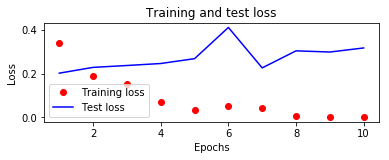

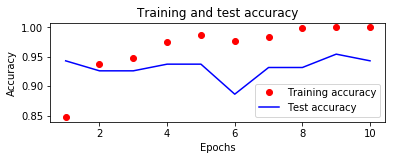

In [76]:
history_dict = history_inception_v3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, history_inception_v3.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(2,1,2)
plt.plot(epochs, history_inception_v3.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# ResNet 50 architecture

In [16]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import preprocess_input
resnet50_model = resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(300,300,3))

resnet50_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
import cv2
x2 = []
for i in range(len(x)):
    if(i%100 == 0):
      print(i)
    img = x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = resnet50_model.predict(img.reshape(1,300,300,3))
    x2.append(img_new)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


In [18]:
x2 = np.array(x2)
x2.shape

(1751, 1, 10, 10, 2048)

In [19]:
x2= x2.reshape(x2.shape[0],x2.shape[2],x2.shape[3],x2.shape[4])
x2.shape

(1751, 10, 10, 2048)

In [0]:
Y = np.array(y2)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x2,Y, test_size=0.1, random_state=42)

In [22]:
model_resnet50 = Sequential()
model_resnet50.add(Conv2D(512, kernel_size=(3, 3), activation='relu',input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
model_resnet50.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet50.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model_resnet50.add(MaxPooling2D(pool_size=(2, 2)))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(1, activation='sigmoid'))
model_resnet50.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 512)         9437696   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 512)         2359808   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
____

In [23]:
model_resnet50.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
np.max(X_train)

119.0767

In [25]:
history_resnet50 = model_resnet50.fit(X_train/np.max(X_train), y_train, batch_size=32,epochs=10,verbose=1,validation_data = (X_test/np.max(X_train), y_test))	

Train on 1575 samples, validate on 176 samples
Epoch 1/10
1575/1575 [==============================] - 6s 4ms/sample - loss: 0.3078 - acc: 0.8590 - val_loss: 0.1926 - val_acc: 0.9261
Epoch 2/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.1290 - acc: 0.9556 - val_loss: 0.2675 - val_acc: 0.9148
Epoch 3/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.0857 - acc: 0.9727 - val_loss: 0.2155 - val_acc: 0.9091
Epoch 4/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.0521 - acc: 0.9829 - val_loss: 0.2838 - val_acc: 0.9205
Epoch 5/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.0350 - acc: 0.9886 - val_loss: 0.2905 - val_acc: 0.9261
Epoch 6/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.0102 - acc: 0.9968 - val_loss: 0.4288 - val_acc: 0.9034
Epoch 7/10
1575/1575 [==============================] - 3s 2ms/sample - loss: 0.0298 - acc: 0.9943 - val_loss: 0.3170 - val_acc: 0.9148
E

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


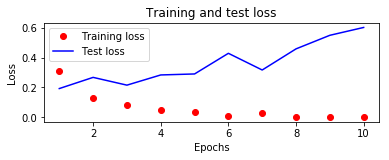

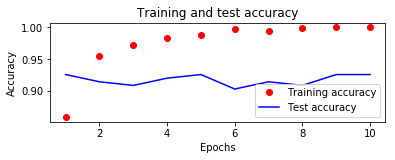

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history_resnet50.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, history_resnet50.history['loss'], 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(2,1,2)
plt.plot(epochs, history_resnet50.history['acc'], 'ro', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

# Visualizing the output intermediate layers

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


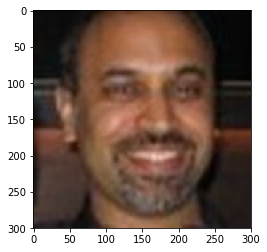

In [27]:
plt.imshow(x[3])
plt.grid('off')

In [28]:
np.max(X_train)

119.0767

In [30]:
from tensorflow.keras.applications.vgg16 import preprocess_input
model_vgg16.predict(vgg16_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))/np.max(X_train))

NameError: ignored

In [0]:
for layer in vgg16_model.layers:
  print(layer.name)

In [0]:
from tensorflow.keras import models
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[1].output)
activations = activation_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))

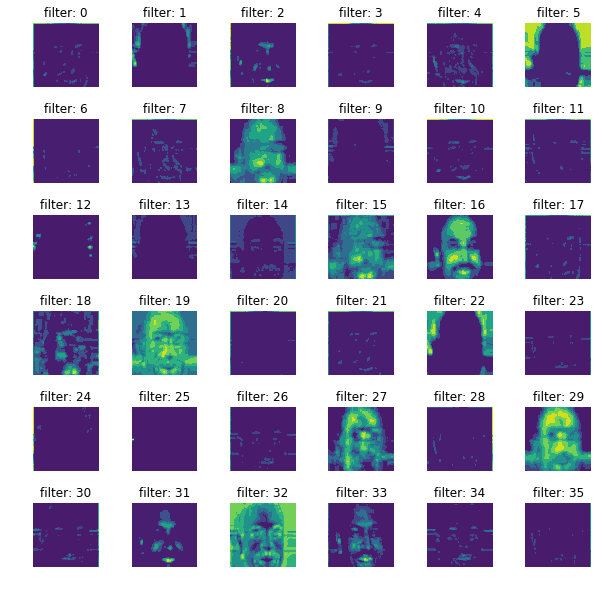

In [93]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
first_layer_activation = activations[0]
for i in range(6):
  for j in range(6):
    try:
      axs[i,j].set_ylim((224, 0))
      axs[i,j].contourf(first_layer_activation[:,:,((6*i)+j)],6,cmap='viridis')
      axs[i,j].set_title('filter: '+str((6*i)+j))
      axs[i,j].axis('off')
    except:
      continue

In [1]:
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[1].output)
activations = activation_model.predict(preprocess_input(np.array(x[:36]).reshape(36,300,300,3)))

NameError: ignored

In [2]:
fig, axs = plt.subplots(6, 6, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)
first_layer_activation = activations
for i in range(6):
  for j in range(6):
    try:
      axs[i,j].set_ylim((224, 0))
      axs[i,j].contourf(first_layer_activation[((6*i)+j),:,:,7],6,cmap='viridis')
      axs[i,j].set_title('filter: '+str((6*i)+j))
      axs[i,j].axis('off')
    except:
      continue

NameError: ignored

In [0]:
activation_model = models.Model(inputs=vgg16_model.input,outputs=vgg16_model.layers[-1].output)
activations = activation_model.predict(preprocess_input(x[3].reshape(1,300,300,3)))

In [0]:
last_layer_activation.shape

(1, 9, 9, 512)

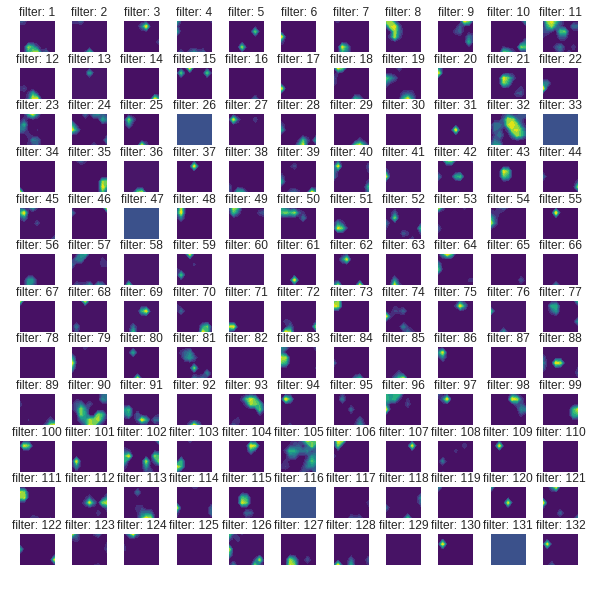

In [0]:
fig, axs = plt.subplots(12, 11, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.5)

last_layer_activation = activations
count = 0
for i in range(12):
  for j in range(11):
    try:
      count+=1
      axs[i,j].set_ylim((6, 0))
      axs[i,j].contourf(last_layer_activation[0,:,:,((12*i)+j)],11,cmap='viridis')
      axs[i,j].set_title('filter: '+str(count))
      axs[i,j].axis('off')
    except:
      continue